# Using Genestack Omics APIs for eQTL analysis

### 1. Connect to the instance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, time
import integration_curator # Genestack client library

os.environ['PRED_SPOT_HOST'] = 'occam.genestack.com'
os.environ['PRED_SPOT_TOKEN'] = '<token>'
os.environ['PRED_SPOT_VERSION'] = 'default-released'

omics_api = integration_curator.OmicsQueriesApi()

### 2. Get samples

In [2]:
study_filter = 'genestack:accession=GSF535886'
sample_filter = ' OR '.join(['"Species Or Strain"="%s"' % x 
                             for x in ['British', 'Finnish']])

start = time.time()
data = omics_api.search_samples(
    study_filter=study_filter, 
    sample_filter=sample_filter
)
samples = pd.DataFrame.from_dict([item['metadata'] for item in data.data])
print('Time to get %s samples: %i seconds\n' % (samples.shape[0], time.time()-start))

samples[['genestack:accession', "Species Or Strain"]].head()

Time to get 182 samples: 0 seconds



,genestack:accession,Species Or Strain
0,GSF535900,British
1,GSF535899,British
2,GSF535902,British
3,GSF535901,British
4,GSF535896,British


### 3. Get genotypes

In [3]:
variant = 'rs17007017'
vx_query = 'VariationId=%s' % variant

start = time.time()
data = omics_api.search_variant_data(
    study_filter=study_filter,
    sample_filter=sample_filter,
    vx_query=vx_query
)
def normalise_genotype(gt): return '1|0' if gt == '0|1' else gt
genotypes = pd.DataFrame.from_dict({'genestack:accession': item['relationships']['sample'], 
                                      'genotype': normalise_genotype(item['genotype']['GT'])} 
                                   for item in data.data)
print('Time to get %s genotypes: %i seconds\n' % (genotypes.shape[0], time.time()-start))

genotypes.head()

Time to get 181 genotypes: 4 seconds



,genestack:accession,genotype
0,GSF535888,1|0
1,GSF535889,0|0
2,GSF535890,1|0
3,GSF535891,1|0
4,GSF535892,0|0


### 4. Get expression data

In [4]:
gene = 'ENSG00000109445'
ex_query = 'Gene=%s MinValue=0.0' % gene

start = time.time()
data = omics_api.search_expression_data(
    study_filter=study_filter,
    sample_filter=sample_filter,
    ex_query=ex_query
)
expressions = pd.DataFrame.from_dict({'genestack:accession': item['relationships']['sample'], 
                                      'expression': item['expression']} for item in data.data)
print('Time to get %s expression values: %i seconds\n' % (expressions.shape[0], time.time()-start))

expressions.head()

Time to get 174 expression values: 0 seconds



,genestack:accession,expression
0,GSF535888,49.420401
1,GSF535889,40.241646
2,GSF535890,34.086207
3,GSF535891,50.219211
4,GSF535892,59.593219


### 5. eQTL plot

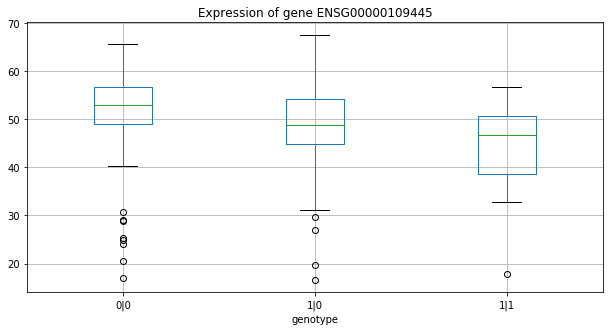

In [5]:
combined_data = pd.merge(samples, pd.merge(genotypes, expressions))
combined_data.boxplot('expression', 'genotype', rot=0, figsize=(10,5))
plt.title('Expression of gene %s' % gene)
x = plt.suptitle('')